# A/B experiment analysis

In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

In [2]:
experiment = "RECOMMENDERS"
DATA_PATH = "../botify/data/"

In [3]:
data = pd.read_json(DATA_PATH + "data.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [4]:
data.head(5)

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2022-06-24 18:53:59.211,3255,2659,1.00,3.953e-04,1725.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4
1,next,2022-06-24 18:53:59.222,3255,1725,0.12,3.350e-04,1537.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4
2,next,2022-06-24 18:53:59.232,3255,1537,0.99,3.333e-04,1995.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4
3,next,2022-06-24 18:53:59.243,3255,1995,1.00,4.370e-04,3590.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4
4,next,2022-06-24 18:53:59.254,3255,3590,0.45,3.266e-04,8096.0,"{'AA': 'C', 'RECOMMENDERS': 'T4'}",T4


## Visualize sessions

In [5]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [6]:
def create_sessions(data_):
    sessions = (
        data_
    #     .loc[(data["treatment"] == 'T3') | (data["treatment"] == 'T4') | (data["treatment"] == 'C')]
        .groupby(["user", "treatment"])
        .apply(sessionize)
        .explode()
        .apply(pd.Series)
    )
    return sessions.copy()

sessions = create_sessions(data)

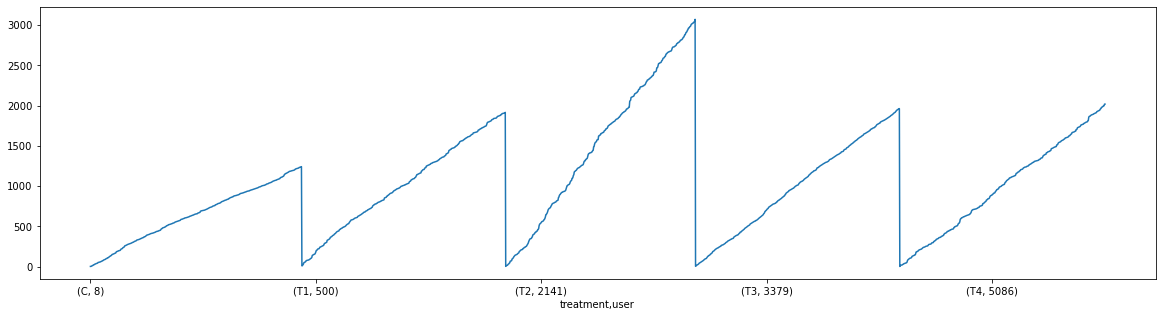

In [7]:
def plot_cumsum_time_per_recomender(sessions_):
    sessions.groupby(["treatment", "user"]).sum("time").groupby(level=0).cumsum()["time"].plot(x = "user", figsize=(20,5))
    pass

plot_cumsum_time_per_recomender(sessions)

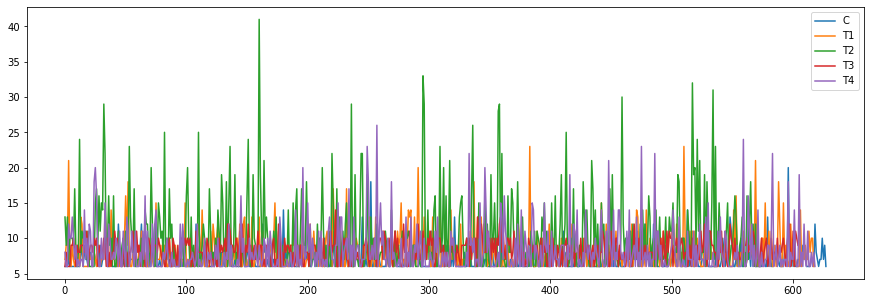

In [8]:
def plot_tracks_per_session(sessions_):
    figure, ax = plt.subplots(figsize=(15, 5))
    for treatment, treatment_sessions in sessions_.groupby("treatment"):
        reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
        ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
    ax.legend()
    pass

plot_tracks_per_session(sessions)

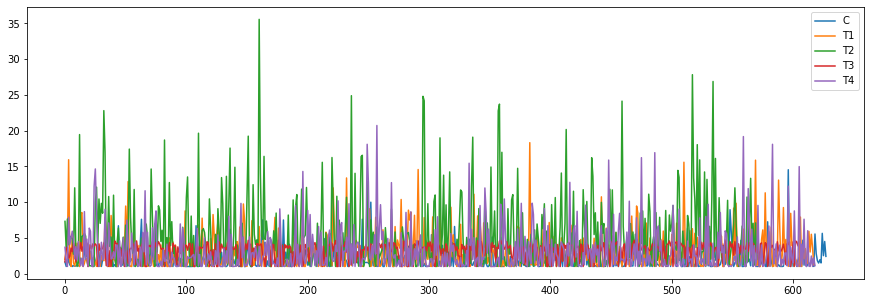

In [9]:
def plot_time_per_session(sessions_):
    figure, ax = plt.subplots(figsize=(15, 5))
    for treatment, treatment_sessions in sessions_.groupby("treatment"):
        reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
        ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
    ax.legend()
    pass

plot_time_per_session(sessions)

## Analyze the experiment

In [10]:
metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

def create_user_lvl_metrics(sessions_):
    user_level_data = (
      sessions_
        .reset_index()
        .groupby(["user", "treatment"])
        .agg(
            {
                "timestamp": "count",
                "tracks": "sum",
                "time": "sum",
                "latency": "sum"
            }
        )
    )

    user_level_data["sessions"] = user_level_data["timestamp"]
    user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
    user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
    user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

    user_level_metrics = user_level_data[metrics].copy().reset_index()
    return user_level_metrics

user_level_metrics = create_user_lvl_metrics(sessions)

In [11]:
def create_treatment_level_metrics(user_level_metrics_):
    treatment_level_metrics = (
        user_level_metrics_
        .groupby("treatment")[metrics]
        .agg(["count", "mean", "var"])
    )
    return treatment_level_metrics.copy()

treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)

In [12]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)

def create_effects(treatment_level_metrics_):
    effects = []

    control = [data for treatment, data in treatment_level_metrics_.iterrows() if treatment == "C"][0]

    for treatment, row in treatment_level_metrics_.iterrows():
        if treatment == "C":
            continue

        for metric in metrics:
            control_mean = control[metric]["mean"]
            treatment_mean = row[metric]["mean"]

            effect = treatment_mean - control_mean
            conf_int = ci(
                control[metric]["count"],
                row[metric]["count"],
                control[metric]["var"],
                row[metric]["var"],
            )
            effects.append({
                "treatment": treatment,
                "metric": metric,
                "control_mean": control_mean,
                "treatment_mean": treatment_mean,
                "effect": effect / control_mean * 100,
                "lower": (effect - conf_int) / control_mean * 100,
                "upper": (effect + conf_int) / control_mean * 100,
                "significant": (effect + conf_int) * (effect - conf_int) > 0
            })
    return effects

effects = create_effects(treatment_level_metrics)

In [13]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        
def print_AB_results(effects_): 
    result = (
        pd.DataFrame(effects_)[[
            "treatment", 
            "metric",
            "effect", 
            "upper", 
            "lower", 
            "control_mean", 
            "treatment_mean",
            "significant"
        ]]
        .sort_values("treatment", ascending=False)
        .style
        .applymap(color, subset=["effect", "upper", "lower"])
        .applymap(background, subset=["significant"])
    )
    return result

print_AB_results(effects)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
19,T4,mean_time_per_session,61.242,76.611,45.873,2.047,3.300,True
18,T4,mean_tracks_per_session,18.659,23.407,13.911,7.017,8.327,True
17,T4,mean_request_latency,-37.218,-34.725,-39.711,0.633,0.397,True
16,T4,sessions,1.377,7.477,-4.723,1.339,1.357,False
15,T4,time,67.241,84.580,49.902,2.649,4.429,True
11,T3,sessions,-0.260,5.811,-6.330,1.339,1.336,False
14,T3,mean_time_per_session,58.837,66.869,50.804,2.047,3.251,True
13,T3,mean_tracks_per_session,17.551,20.481,14.620,7.017,8.249,True
12,T3,mean_request_latency,51.394,54.963,47.826,0.633,0.958,True
10,T3,time,63.644,74.634,52.654,2.649,4.334,True


# Top Pop Comparison experiments
### Top 1000

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
24,T5,mean_time_per_session,43.060,53.690,32.430,2.069,2.960,True
23,T5,mean_tracks_per_session,12.465,15.837,9.093,7.068,7.949,True
22,T5,mean_request_latency,124.598,127.412,121.783,0.630,1.415,True
21,T5,sessions,1.207,5.916,-3.501,1.268,1.283,False
20,T5,time,46.735,58.918,34.551,2.564,3.763,True
19,T4,mean_time_per_session,46.192,57.503,34.882,2.069,3.025,True
18,T4,mean_tracks_per_session,14.057,17.642,10.472,7.068,8.061,True
17,T4,mean_request_latency,126.356,129.542,123.169,0.630,1.426,True
16,T4,sessions,4.316,9.097,-0.465,1.268,1.322,False
15,T4,time,54.828,67.663,41.992,2.564,3.971,True


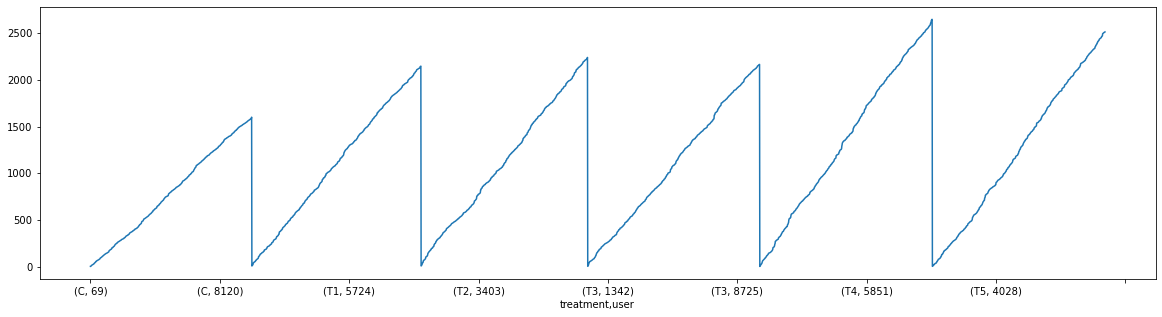

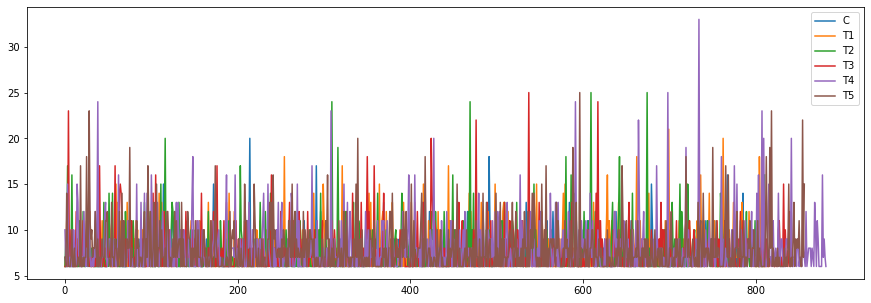

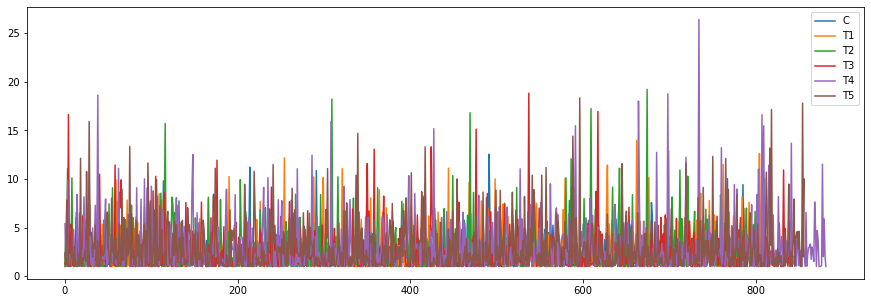

In [14]:
# getting data

# T1 TopPop on Random
# T2 TopPop on StickyArtist
# T3 TopPop on TopPop
# T4 TopPop on Collaborative
# T5 TopPop on Contextual
# C Random
# Top 1000
experiment = "TOP_POP_COMPARISON"

data = pd.read_json(DATA_PATH + "top_pop_experiment/data_1000.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### Top 100

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
24,T5,mean_time_per_session,78.070,91.881,64.260,2.073,3.692,True
23,T5,mean_tracks_per_session,22.730,26.976,18.485,7.096,8.709,True
22,T5,mean_request_latency,-36.510,-34.327,-38.694,0.607,0.385,True
21,T5,sessions,-0.273,4.215,-4.761,1.245,1.242,False
20,T5,time,75.567,90.676,60.458,2.588,4.543,True
19,T4,mean_time_per_session,89.648,107.149,72.147,2.073,3.932,True
18,T4,mean_tracks_per_session,26.080,31.342,20.818,7.096,8.946,True
17,T4,mean_request_latency,-36.313,-34.060,-38.566,0.607,0.386,True
16,T4,sessions,3.041,7.595,-1.512,1.245,1.283,False
15,T4,time,94.266,113.882,74.649,2.588,5.027,True


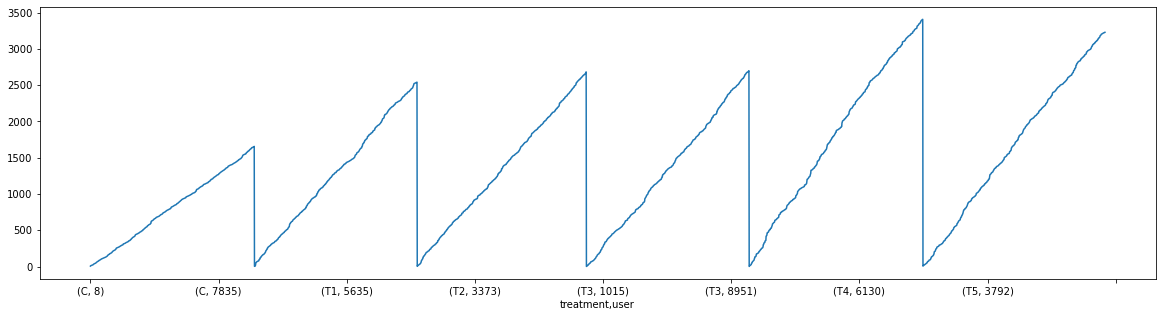

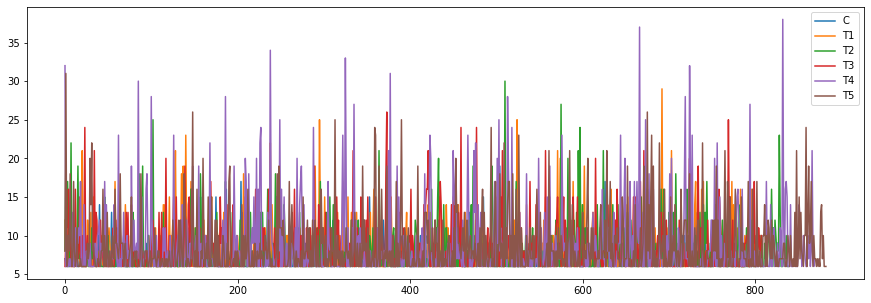

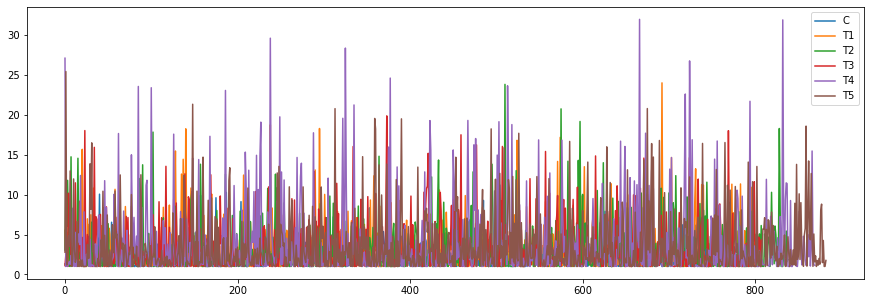

In [15]:
# getting data

# T1 TopPop on Random
# T2 TopPop on StickyArtist
# T3 TopPop on TopPop
# T4 TopPop on Collaborative
# T5 TopPop on Contextual
# C Random
# Top 100
experiment = "TOP_POP_COMPARISON"

data = pd.read_json(DATA_PATH + "top_pop_experiment/data_100.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### Top 80

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
24,T5,mean_time_per_session,43.257,51.478,35.035,2.090,2.994,True
23,T5,mean_tracks_per_session,12.568,15.145,9.992,7.081,7.971,True
22,T5,mean_request_latency,120.307,122.525,118.090,0.619,1.364,True
21,T5,sessions,1.839,6.723,-3.044,1.676,1.707,False
20,T5,time,45.528,55.479,35.577,3.447,5.017,True
19,T4,mean_time_per_session,44.486,53.076,35.896,2.090,3.020,True
18,T4,mean_tracks_per_session,13.641,16.328,10.954,7.081,8.047,True
17,T4,mean_request_latency,121.795,124.050,119.540,0.619,1.373,True
16,T4,sessions,4.787,9.736,-0.161,1.676,1.757,False
15,T4,time,51.356,61.921,40.791,3.447,5.218,True


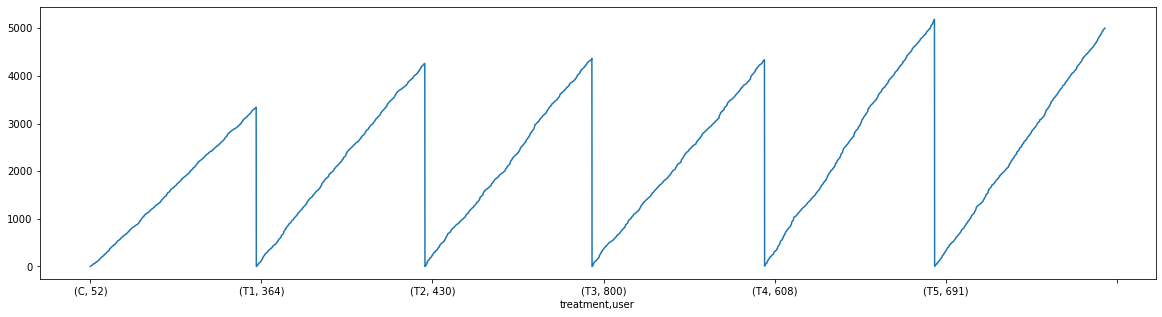

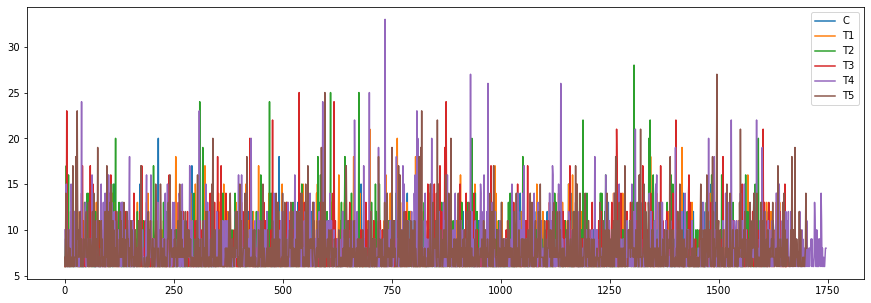

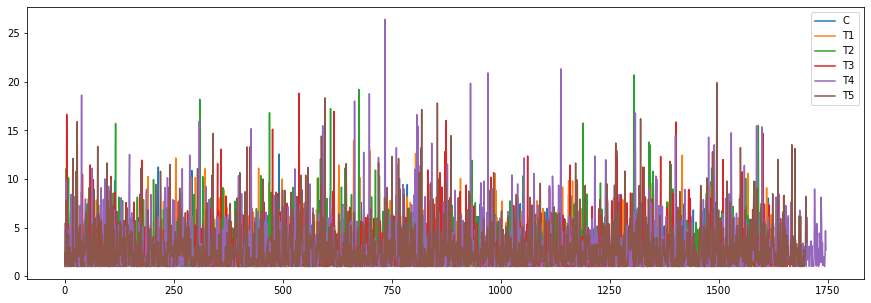

In [16]:
# getting data

# T1 TopPop on Random
# T2 TopPop on StickyArtist
# T3 TopPop on TopPop
# T4 TopPop on Collaborative
# T5 TopPop on Contextual
# C Random
# Top 80
experiment = "TOP_POP_COMPARISON"

data = pd.read_json(DATA_PATH + "top_pop_experiment/data_80.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)


**Result. The best was the top pop on the data obtained from the Collaborative recommender with only the first 100 tracks from the top.**

# Contextuals comparison (custom contextual with TopPop and filters vs original)
### SIMPLE_FILTER, rec_tolerance = 0.8

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,41.797,51.539,32.055,6.888,9.768,True
1,T1,sessions,-1.422,1.156,-4.000,1.264,1.246,False
2,T1,mean_request_latency,145.075,146.716,143.434,0.721,1.767,True
3,T1,mean_tracks_per_session,22.355,27.171,17.540,10.433,12.765,True
4,T1,mean_time_per_session,43.380,52.529,34.232,5.416,7.765,True


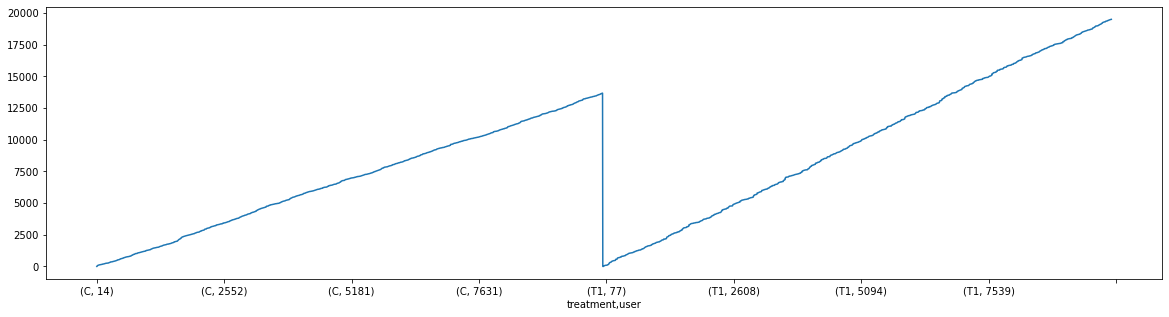

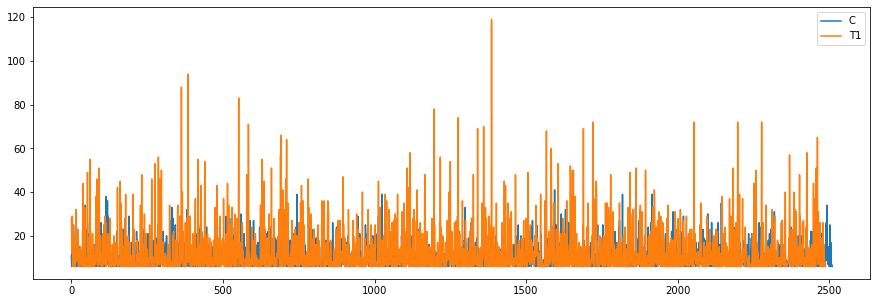

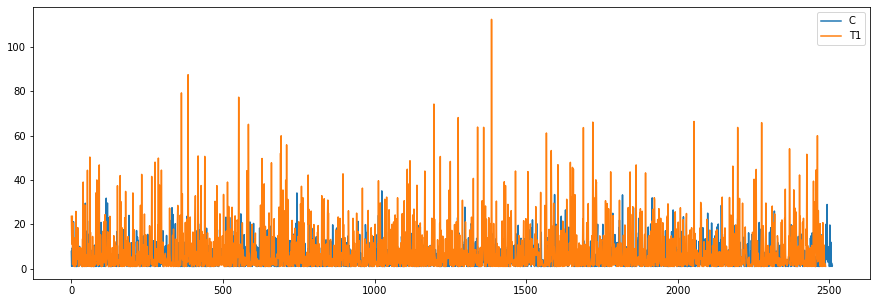

In [17]:
# getting data

# T1 TopPop on Custom Contextual
# C Contextual

# 5000 iterations with SIMPLE_FILTER, rec_tolerance = 0.8
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_1.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### SIMPLE_FILTER, rec_tolerance = 0.75

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,49.419,59.628,39.209,7.188,10.740,True
1,T1,sessions,-0.087,2.579,-2.752,1.271,1.270,False
2,T1,mean_request_latency,142.604,144.624,140.585,0.725,1.758,True
3,T1,mean_tracks_per_session,26.882,32.286,21.479,10.654,13.518,True
4,T1,mean_time_per_session,50.350,60.347,40.353,5.656,8.504,True


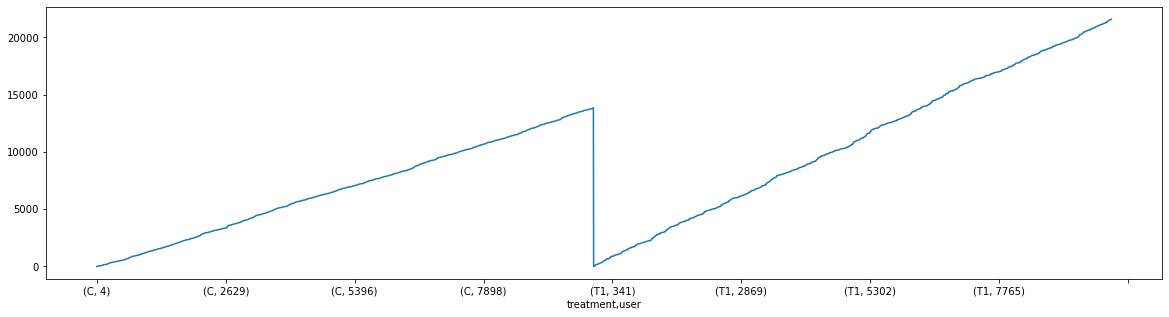

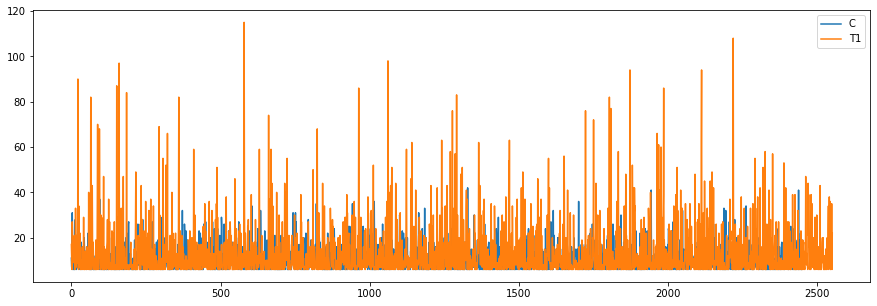

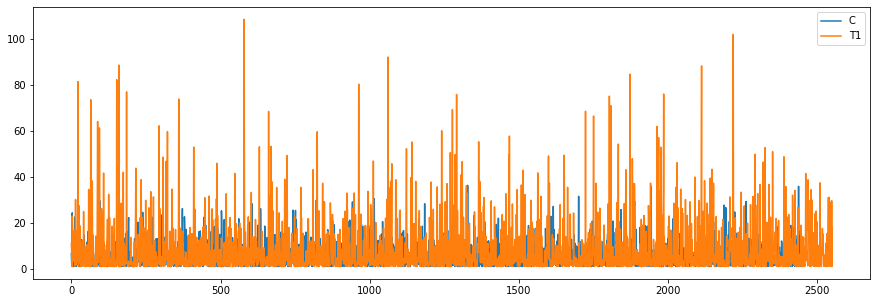

In [18]:
# getting data

# T1 TopPop on Custom Contextual
# C Contextual

# 5000 iterations with SIMPLE_FILTER, rec_tolerance = 0.75
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_2.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### SIMPLE_FILTER, rec_tolerance = 0.7

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,50.988,61.366,40.611,6.981,10.540,True
1,T1,sessions,1.336,4.052,-1.381,1.266,1.282,False
2,T1,mean_request_latency,141.624,143.476,139.771,0.735,1.777,True
3,T1,mean_tracks_per_session,23.871,28.850,18.891,10.586,13.113,True
4,T1,mean_time_per_session,46.194,55.556,36.831,5.561,8.130,True


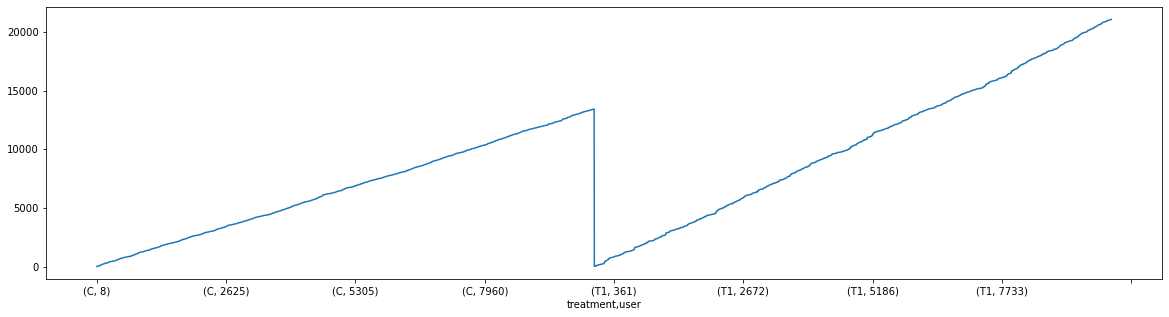

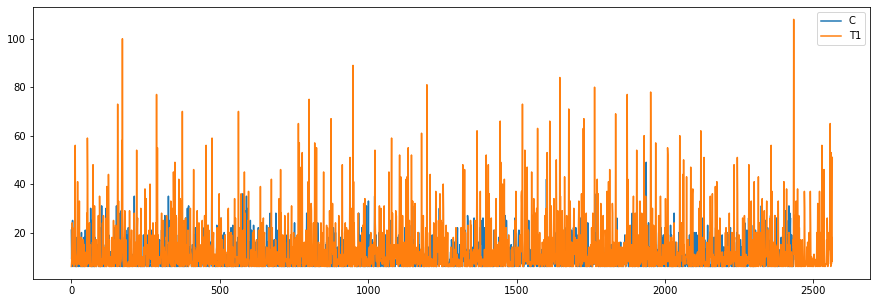

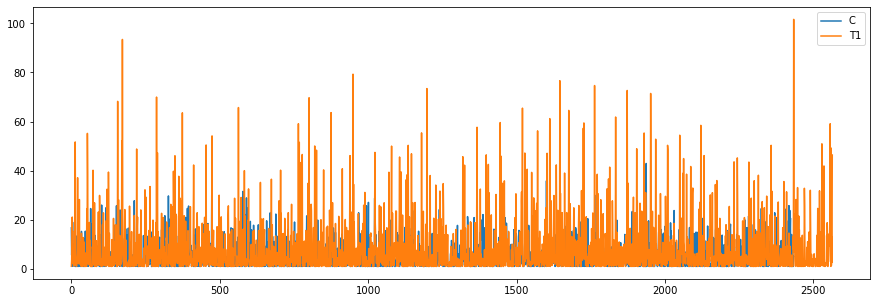

In [19]:
# getting data

# T1 Custom Contextual
# C Contextual

# 5000 iterations with SIMPLE_FILTER, rec_tolerance = 0.7
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_3.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### SIMPLE_FILTER, rec_tolerance = 0.65

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,60.955,71.428,50.482,6.559,10.557,True
1,T1,sessions,1.519,4.230,-1.193,1.266,1.285,False
2,T1,mean_request_latency,147.966,149.675,146.257,0.693,1.719,True
3,T1,mean_tracks_per_session,30.879,36.186,25.571,10.231,13.390,True
4,T1,mean_time_per_session,60.689,70.911,50.467,5.231,8.406,True


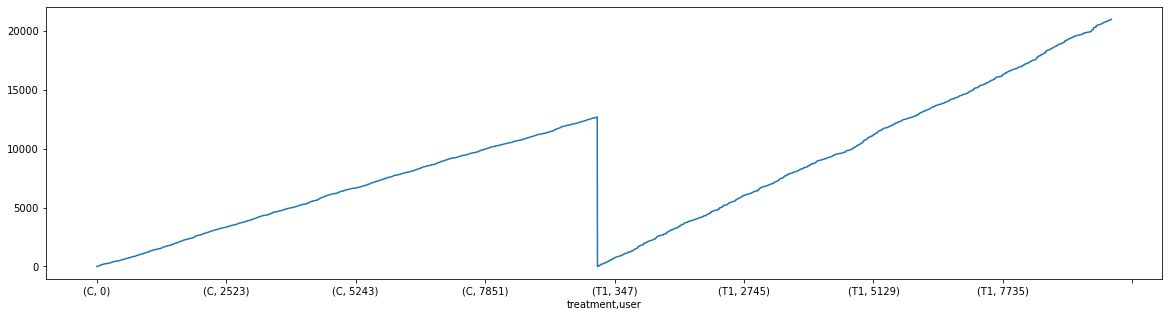

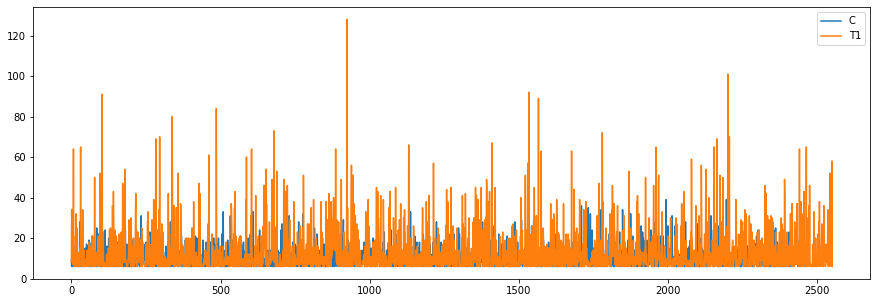

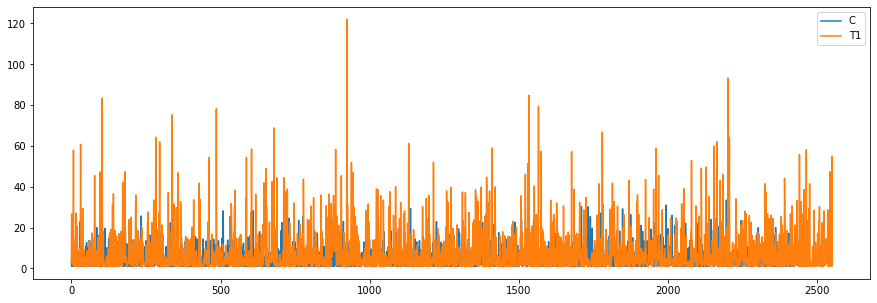

In [20]:
# getting data

# T1 Custom Contextual
# C Contextual

# 5000 iterations with SIMPLE_FILTER, rec_tolerance = 0.65
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_4.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### Test compare random, original, 0.60, 0.65

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
10,T3,time,158.992,173.230,144.755,3.191,8.263,True
11,T3,sessions,1.027,4.596,-2.543,1.518,1.533,False
12,T3,mean_request_latency,6.126,7.233,5.019,0.670,0.711,True
13,T3,mean_tracks_per_session,44.802,48.369,41.236,7.118,10.307,True
14,T3,mean_time_per_session,150.143,161.780,138.507,2.130,5.329,True
5,T2,time,318.000,346.827,289.172,3.191,13.337,True
6,T2,sessions,1.364,4.957,-2.229,1.518,1.538,False
7,T2,mean_request_latency,159.093,160.837,157.349,0.670,1.735,True
8,T2,mean_tracks_per_session,91.032,98.510,83.554,7.118,13.597,True
9,T2,mean_time_per_session,303.797,328.541,279.053,2.130,8.602,True


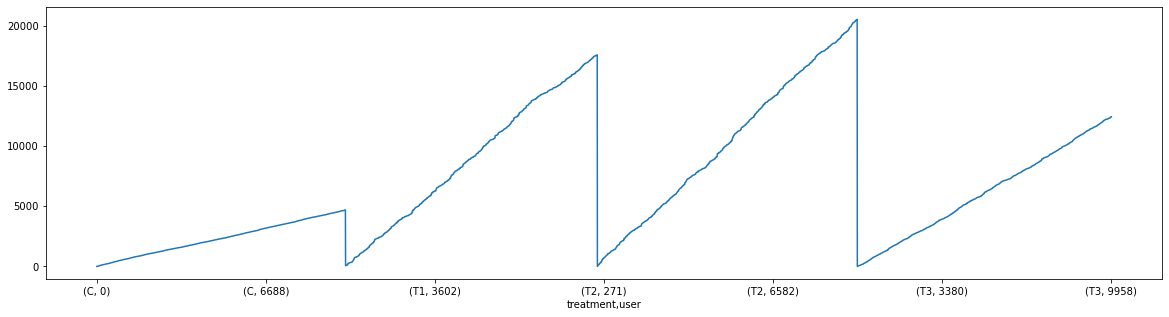

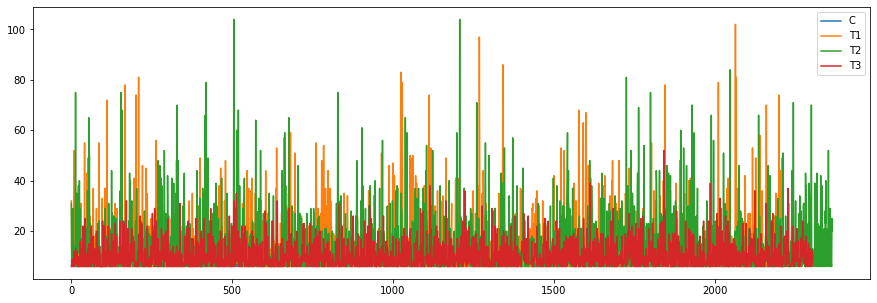

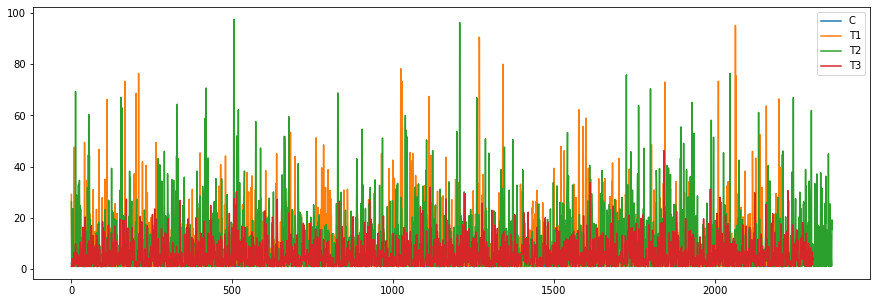

In [22]:
# getting data

# T1 Contextual with TopPop and filter SIMPLE 0.65
# T2 Contextual with TopPop and filter SIMPLE 0.60
# T3 Original Contextual
# C Random

# 10000 iterations
experiment = "MANY_CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_test_1.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### SIMPLE_FILTER, rec_tolerance = 0.6

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,59.731,70.106,49.356,6.776,10.823,True
1,T1,sessions,2.028,4.688,-0.633,1.257,1.283,False
2,T1,mean_request_latency,146.515,147.979,145.052,0.699,1.723,True
3,T1,mean_tracks_per_session,29.322,34.338,24.305,10.348,13.382,True
4,T1,mean_time_per_session,56.581,66.118,47.044,5.357,8.388,True


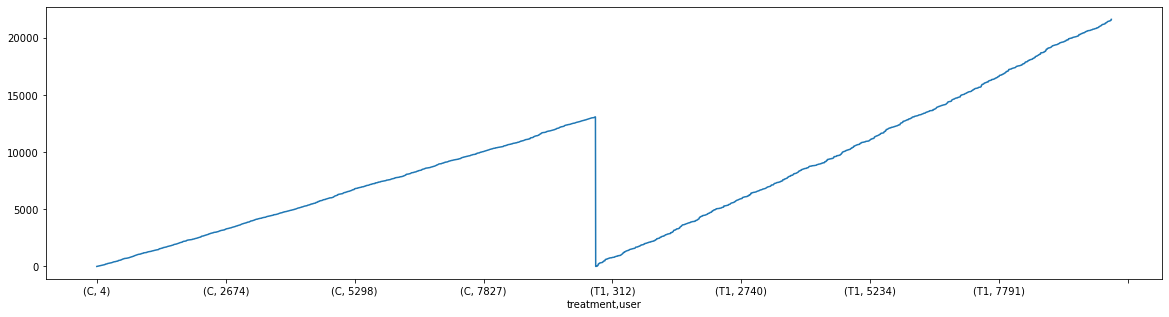

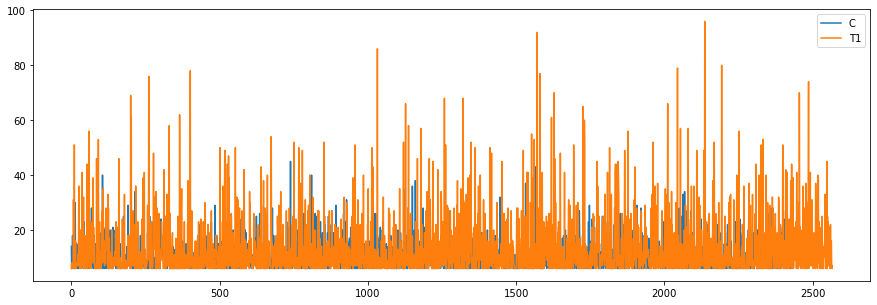

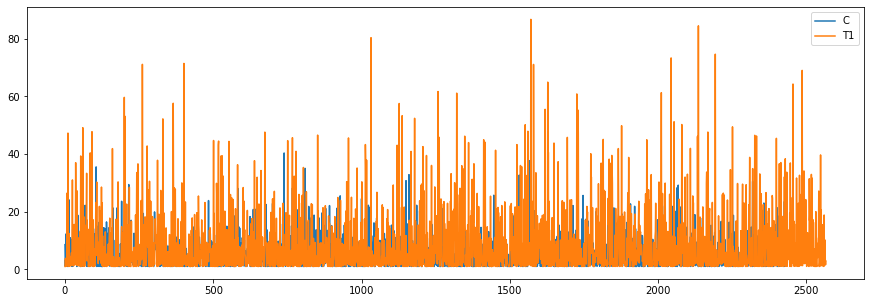

In [23]:
# getting data

# T1 Custom Contextual
# C Contextual

# 5000 iterations with SIMPLE_FILTER, rec_tolerance = 0.6
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_5.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### SIMPLE_FILTER, rec_tolerance = 0.55

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,48.849,58.873,38.826,6.763,10.066,True
1,T1,sessions,0.192,2.820,-2.435,1.263,1.265,False
2,T1,mean_request_latency,146.993,148.671,145.314,0.701,1.731,True
3,T1,mean_tracks_per_session,25.658,30.520,20.796,10.273,12.909,True
4,T1,mean_time_per_session,50.217,59.533,40.901,5.290,7.946,True


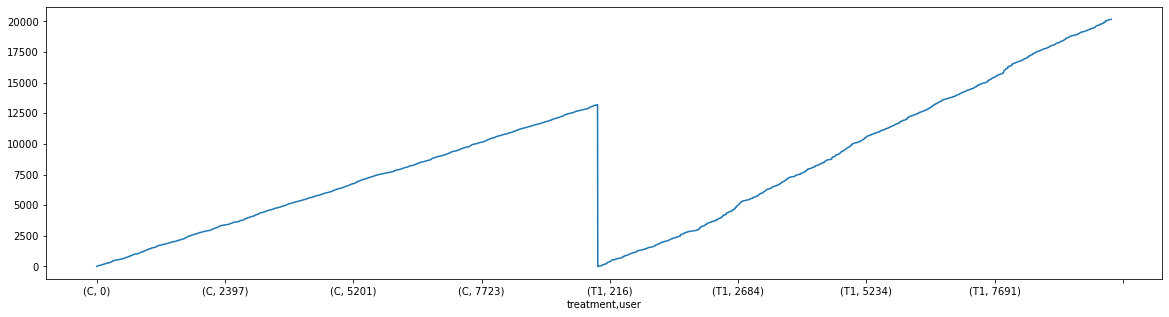

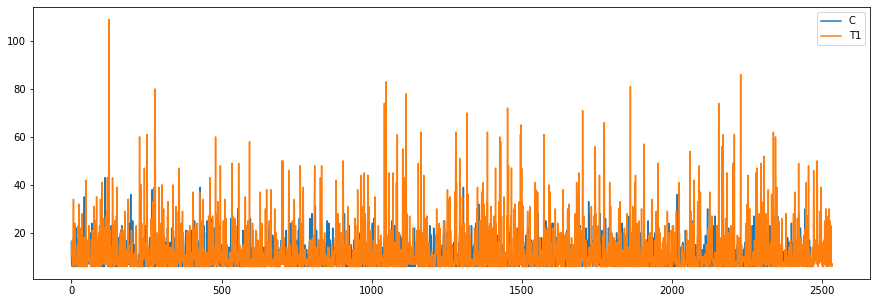

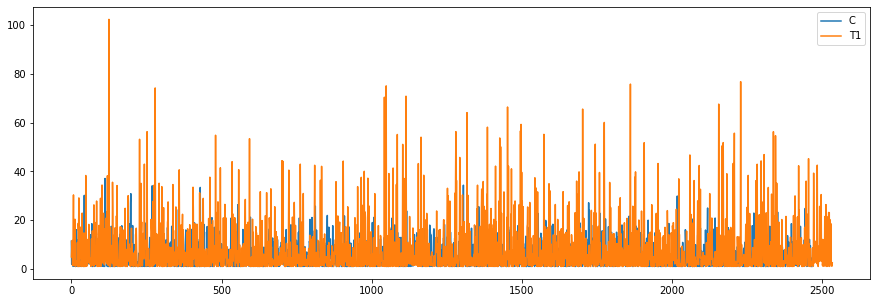

In [24]:
# getting data

# T1 Custom Contextual
# C Contextual

# 5000 iterations with SIMPLE_FILTER, rec_tolerance = 0.55
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_6.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### AUTHOR_TRACK_HISTORY, rec_tolerance = 0.65 artist_tolerance = 2

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,38.458,47.628,29.288,7.158,9.911,True
1,T1,sessions,-1.197,1.423,-3.817,1.285,1.270,False
2,T1,mean_request_latency,2086.159,2108.821,2063.497,0.596,13.038,True
3,T1,mean_tracks_per_session,22.091,26.821,17.360,10.536,12.863,True
4,T1,mean_time_per_session,41.544,50.405,32.682,5.545,7.848,True


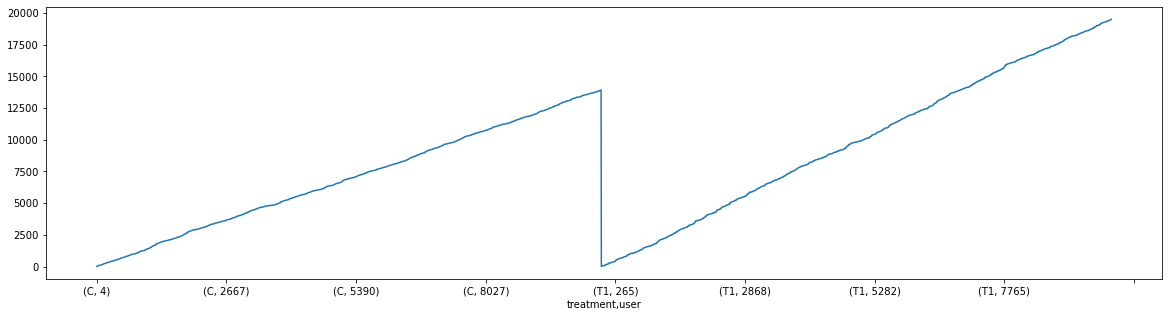

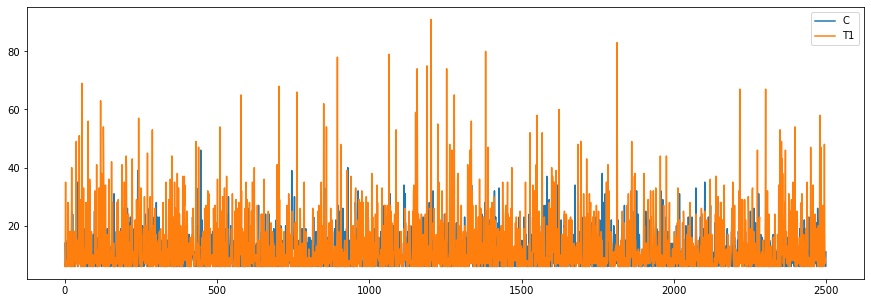

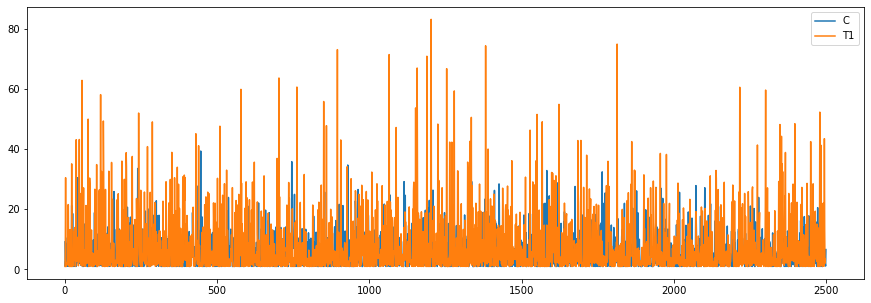

In [25]:
# getting data

# T1 Custom Contextual
# C Contextual

# 5000 iterations with AUTHOR_TRACK_HISTORY, rec_tolerance = 0.65 artist_tolerance = 2
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_7.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### AUTHOR_TRACK_HISTORY, rec_tolerance = 0.65 artist_tolerance = 1

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,63.003,74.063,51.943,6.718,10.951,True
1,T1,sessions,1.087,3.715,-1.540,1.263,1.276,False
2,T1,mean_request_latency,2056.638,2079.368,2033.909,0.629,13.566,True
3,T1,mean_tracks_per_session,31.887,37.156,26.618,10.288,13.569,True
4,T1,mean_time_per_session,62.481,72.584,52.377,5.281,8.581,True


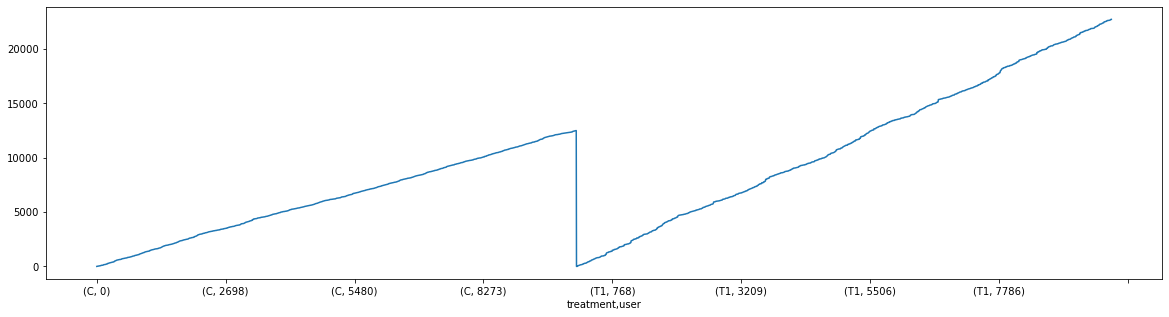

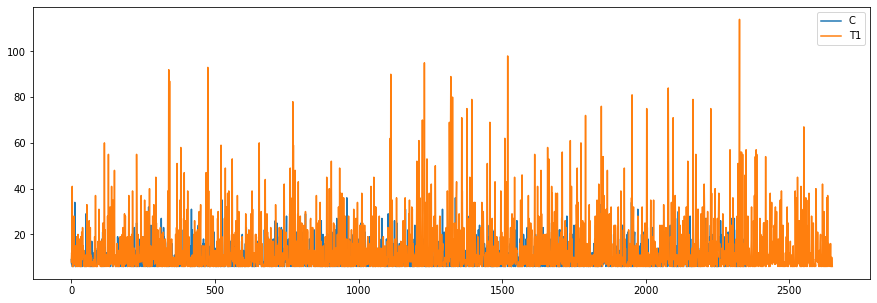

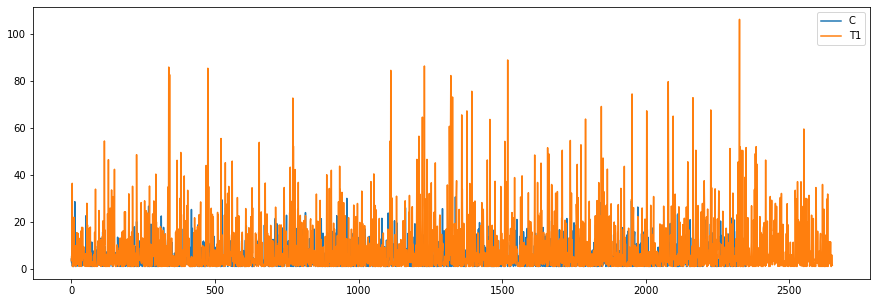

In [26]:
# getting data

# T1 Custom Contextual
# C Contextual

# 5000 iterations with AUTHOR_TRACK_HISTORY, rec_tolerance = 0.65 artist_tolerance = 1
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_8.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### AUTHOR_TRACK_HISTORY, rec_tolerance = 0.65 artist_tolerance = 3

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,48.738,58.663,38.813,6.945,10.329,True
1,T1,sessions,0.064,2.725,-2.597,1.273,1.274,False
2,T1,mean_request_latency,1988.474,2013.128,1963.821,0.676,14.108,True
3,T1,mean_tracks_per_session,26.591,31.682,21.499,10.382,13.142,True
4,T1,mean_time_per_session,51.718,61.414,42.021,5.388,8.175,True


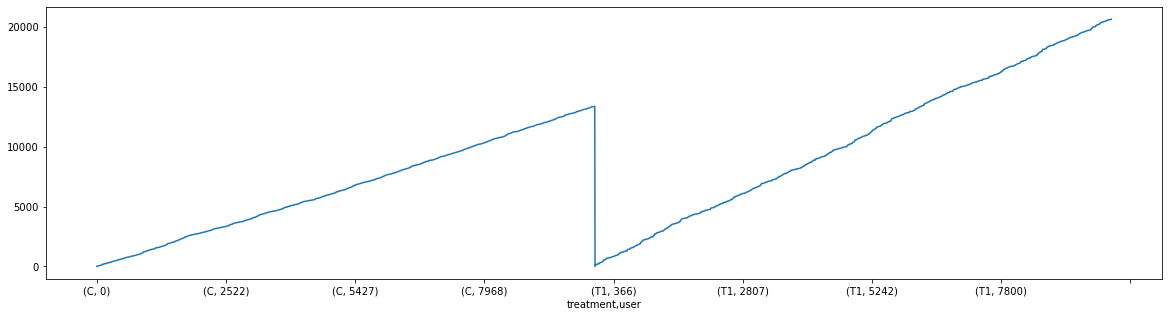

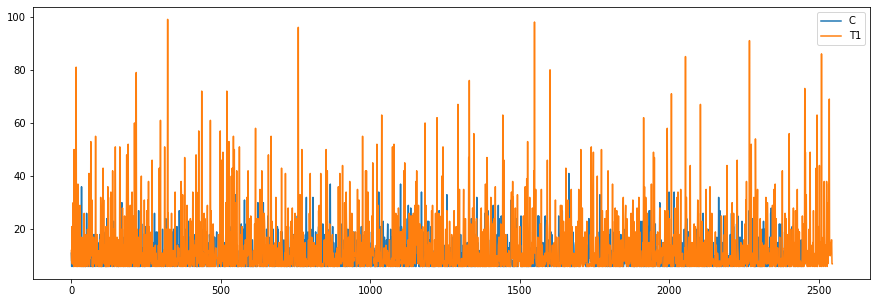

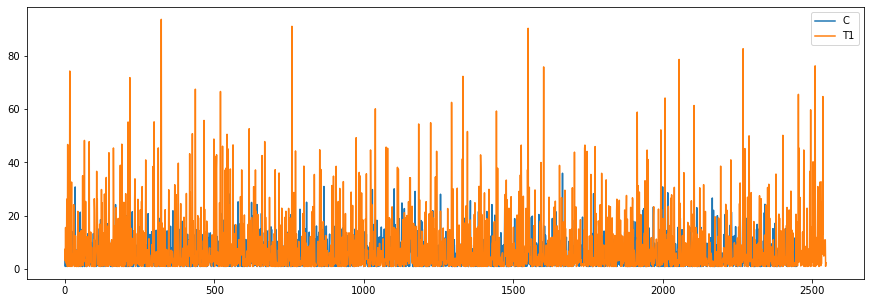

In [27]:
# getting data

# T1 Custom Contextual
# C Contextual

# 5000 iterations with AUTHOR_TRACK_HISTORY, rec_tolerance = 0.65 artist_tolerance = 3
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_9.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)

### AUTHOR_TRACK_HISTORY VS SIMPLE_HISTORY rec_tolerance = 0.65 artist_tolerance = 1

In [ ]:
# getting data

# T1 Custom Contextual AUTHOR_TRACK_HISTORY
# C Custom Contextual SIMPLE_HISTORY

# 5000 iterations with AUTHOR_TRACK_HISTORY, rec_tolerance = 0.65 artist_tolerance = 1
experiment = "CONTEXTUAL_COMPARISON"

data = pd.read_json(DATA_PATH + "contextual_experiment/data_10.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

# data.head(5)

## Visualize sessions

sessions = create_sessions(data)
plot_cumsum_time_per_recomender(sessions)
plot_tracks_per_session(sessions)
plot_time_per_session(sessions)

## Analyze the experiment

user_level_metrics = create_user_lvl_metrics(sessions)
treatment_level_metrics = create_treatment_level_metrics(user_level_metrics)
effects = create_effects(treatment_level_metrics)
print_AB_results(effects)